# Computer Generated Holography

<a target="_blank" href="https://colab.research.google.com/github/TuragaLab/chromatix/blob/main/docs/examples/cgh.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# If in colab, install Jax and chromatix. Don't forget to select a GPU!
!pip install --upgrade pip
!pip install "jax[cuda11_cudnn82]==0.4.1" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install git+https://github.com/TuragaLab/chromatix.git


In this notebook we build a model for simulating computer generated holography (CGH).

In [2]:
import jax
import jax.numpy as jnp
from jax import random
import flax.linen as nn

from optax import adam
import optax

from skimage.data import cells3d
import matplotlib.pyplot as plt

from chromatix import Field
from chromatix.elements import PlaneWave, PhaseMask, FFLens, Propagate

from typing import Sequence, Callable, Any
from chex import Array


key = random.PRNGKey(42)

%config InlineBackend.figure_format='retina'

## Constructing the model

It's easiest to build our own model - it's all standard flax. Flax lazily loads so no need for a __init__:

In [3]:
class CGH(nn.Module):
    @nn.compact
    def __call__(self, z):
        # Parameters are taken from the paper, we just use 256, 256 because of our data 
        field = PlaneWave(shape=(256, 256), dx=9.2, spectrum=1.035, spectral_density=1.0)()
        field = PhaseMask(random.normal)(field)
        field = FFLens(f=200, n=1.0, NA=None)(field) # TODO: Add padding to FFLens
        return Propagate(n=1.0, N_pad=512, method='transfer')(field, z)

We now build an init the model:

In [4]:
model = CGH() 
params = model.init(key, 10.0)

In [5]:
# We can call the model to get the field at a given z:
output_field = model.apply(params, z=10.0)

# This matches the spacing in the paper
print(model.apply(params, z=10.0).grid.max() - model.apply(params, z=10.0).grid.min())

22.412111


In [6]:
# Let's do a model with 11 distances: 
z = jnp.linspace(-50, 50, 11)

# Instead of looping over single distances, 
# we can calculate all distances in parallel by setting this shape:
# Additionally and alternatively you can pmap / vmap over multiple gpus
z = z[:, None, None, None] # matches rank of field, with number of z along batch axis

In [7]:
# The intensity now has shape 11 x 256 x 256 x 1
print(model.apply(params, z).intensity.shape)

(11, 256, 256, 1)


## Prepping data

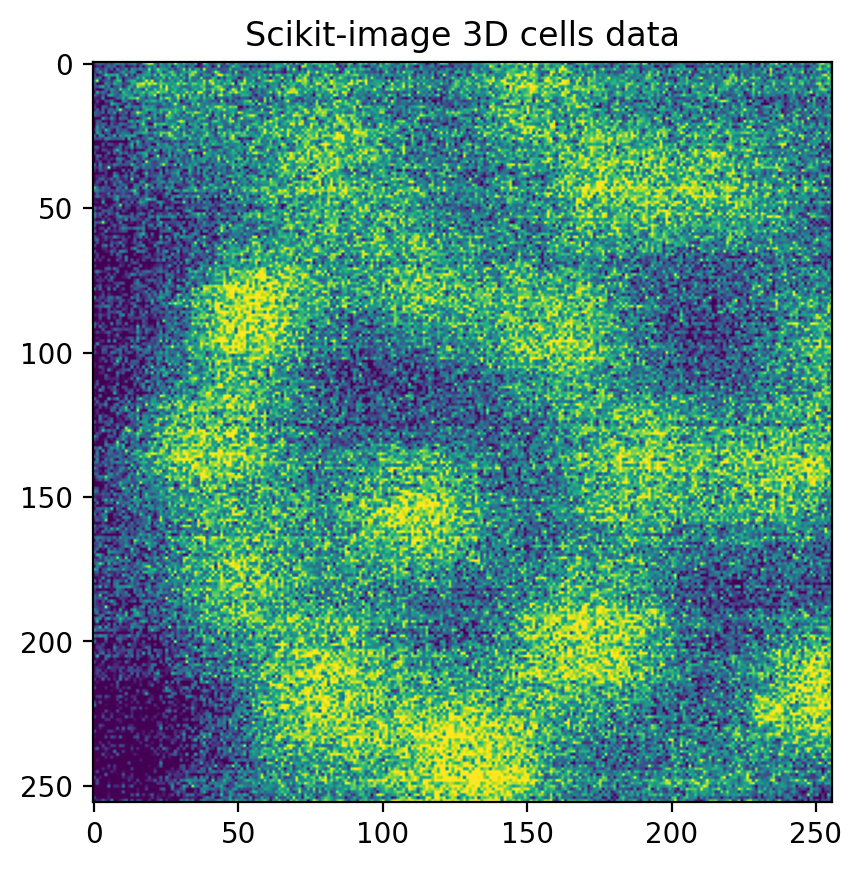

In [8]:
# Now let's load some fake 3D data from skimage.
# Prepping data, we only take the nuclei
data = cells3d()[:, 1]

# Our fake data has shape 60, 256, 256. Let's take the first 11 planes, 
# we just crop the output of the model
data = data[:11]

# Rescale image data to range [0, 1]
data = jnp.clip(data, jnp.percentile(data, 5), jnp.percentile(data, 95))
data = (data - data.min()) / (data.max() - data.min())

# Equalize to unit power on all depths
data = data / (jnp.sum(data, axis=[1, 2], keepdims=True) * output_field.dx.squeeze()**2)

# Plotting the data - TODO: get better version from scikit image
plt.imshow(data[10])
plt.title("Scikit-image 3D cells data")
plt.show()

## Training

In [9]:
# Now let's build a loss function:
def loss_fn(params, data, z):
    eps = 1e-6
    approx = model.apply(params, z=z).intensity.squeeze()
    loss = 1 - (jnp.sum(approx * data) / (jnp.sqrt(jnp.sum(approx**2) * jnp.sum(data**2))) + eps)
    return loss, {"loss": loss}

print(loss_fn(params, data, z))

(Array(0.9945775, dtype=float32), {'loss': Array(0.9945775, dtype=float32)})


In [10]:
# unlike pytorch, Jax doesn't do 'model.backward()'. Rather we define a forward function
# with the parameters as inputs and take gradients from that function:
grad_fn = jax.jit(jax.grad(loss_fn, has_aux=True)) # jit compiles and makes everything go brrrrr
print(grad_fn(params, data, z)[0]["params"]["PhaseMask_0"]["phase_pixels"][0, :4, :4, 0])

[[-4.4000612e-07  5.4186955e-08  1.9057295e-07 -1.7612601e-07]
 [-1.8918959e-07  1.1544520e-07  3.5146176e-08 -1.5282390e-08]
 [-2.7086028e-07  9.0064439e-08  5.8596992e-08 -1.4556487e-07]
 [-2.3548478e-07  1.6124048e-08  5.8686211e-08 -1.8737784e-07]]


In [11]:
# Now we run a little optimization loop. 
# We define the optimizer and initialize the optimizer state
optimizer = adam(learning_rate=1e-2)
opt_state = optimizer.init(params)

In [12]:
# This is one of my little snippets; we want to compile the largest amount of code possible. 
# This function takes in a loss function and optimizer and returns a function which 
# 1 ) calculates the gradients 2) applies them to the parameters and 3) returns all this
# including some metrics of choice
# TL;DR every call to this function updates the model by one step.

def step_fn(loss_fn, optimizer):
    def step(params, opt_state, *args):
        (_, metrics), grads = jax.value_and_grad(loss_fn, allow_int=True, has_aux=True)(
            params, *args
        )
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, metrics
    return step

step = jax.jit(step_fn(loss_fn, optimizer))

In [13]:
%%time
# Now we train
max_iterations = 1000 # only 1000 as I'm running on my laptop
history = []
for iteration in range(max_iterations):
    params, opt_state, metrics = step(params, opt_state, data, z)
    history.append(metrics["loss"])
    if iteration % 250 == 0:
        print(iteration, metrics)

0 {'loss': Array(0.9945775, dtype=float32)}
250 {'loss': Array(0.48881274, dtype=float32)}
500 {'loss': Array(0.4426825, dtype=float32)}
750 {'loss': Array(0.42469645, dtype=float32)}
CPU times: user 3min 21s, sys: 23.3 s, total: 3min 44s
Wall time: 2min 30s


## Evaluation

Text(0.5, 1.0, 'True at 50.0')

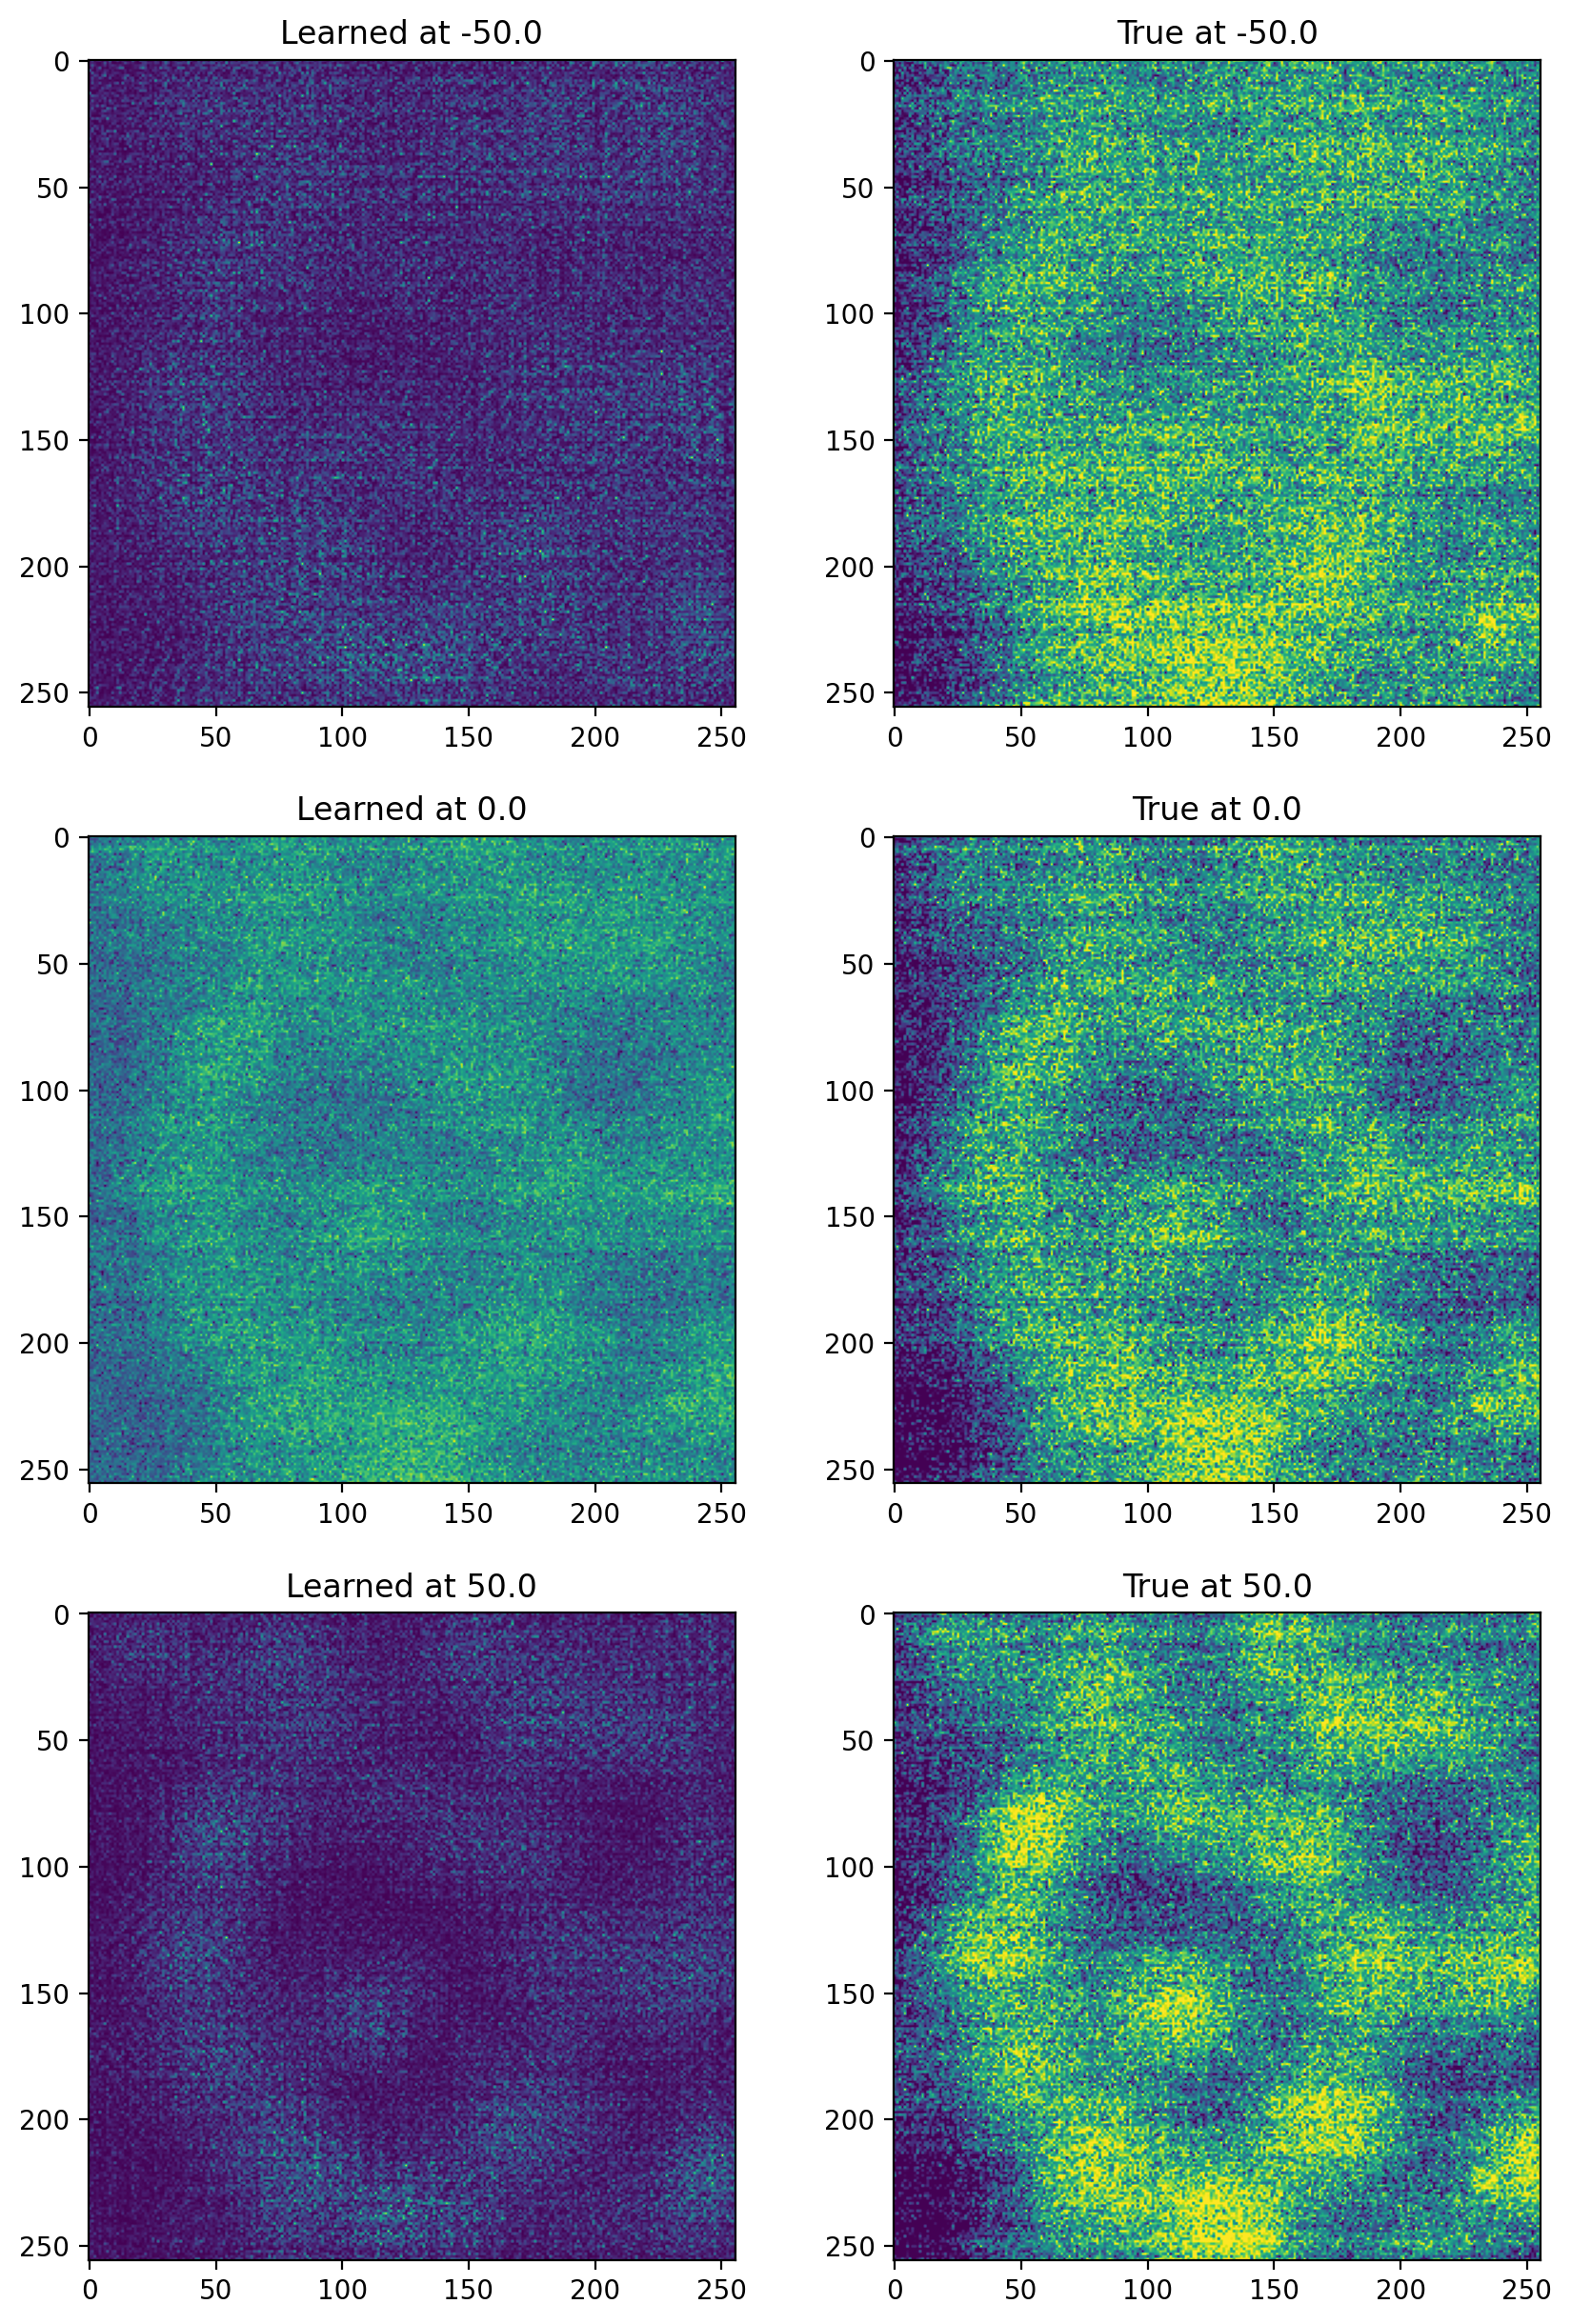

In [14]:
# Let's see how we did!
learned = model.apply(params, z).intensity.squeeze()

plt.figure(figsize=(10, 15))
depth = 0
plt.subplot(321)
plt.imshow(learned[depth])
plt.title(f"Learned at {z[depth].squeeze()}")

plt.subplot(322)
plt.imshow(data[depth])
plt.title(f"True at {z[depth].squeeze()}")

depth = 5
plt.subplot(323)
plt.imshow(learned[depth])
plt.title(f"Learned at {z[depth].squeeze()}")

plt.subplot(324)
plt.imshow(data[depth])
plt.title(f"True at {z[depth].squeeze()}")


depth = 10
plt.subplot(325)
plt.imshow(learned[depth])
plt.title(f"Learned at {z[depth].squeeze()}")

plt.subplot(326)
plt.imshow(data[depth])
plt.title(f"True at {z[depth].squeeze()}")

So we didn't do extremely well, but that's to be expected with this very low amount of pixels!